# Barbalat Detumble
Rather than use a discrete time, nonmonotonic Lyapunov function, we use Barbalat's lemma to derive a continuous time control law. It involves solving a quadratically constrained quadratic program,
\begin{align*}
&\mathrm{minimize} &&-h^T \hat{B} u\\
&\mathrm{w.r.t.} && u, \dot{u} \\
&\mathrm{s.t.} && u^T \hat{B}^T \hat{B} u - h^T \left(\hat{B} \dot{u} +\hat{\dot{B}}u\right) \leq \epsilon \\
&&& u_\mathrm{min} \leq u \leq u_\mathrm{max} \\
&&& u_\mathrm{min} \leq u + \Delta t \dot{u} \leq u_\mathrm{max}
\end{align*}



In [4]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
import SatelliteDynamics
using Random
import Convex, COSMO
Random.seed!(0)

include("../src/satellite_simulator.jl")
include("../src/detumble_controller.jl")
include("../src/satellite_models.jl")

  Activating project at `~/research/non-monotonic-detumbling`


3×3 Matrix{Float64}:
 0.001  0.0    0.0
 0.0    0.003  0.0
 0.0    0.0    0.005

In [5]:

params = OrbitDynamicsParameters(py4_model_diagonal;
    distance_scale=1.0,
    time_scale=1.0,
    angular_rate_scale=1.0,
    control_scale=1,
    control_type=:dipole,
    magnetic_model=:IGRF13,
    add_solar_radiation_pressure=true,
    add_sun_thirdbody=true,
    add_moon_thirdbody=true)

x_osc_0 = [400e3 + SatelliteDynamics.R_EARTH, 0.0, deg2rad(50), deg2rad(-1.0), 0.0, 0.0] # a, e, i, Ω, ω, M
# x_osc_0 = [525e3 + SatelliteDynamics.R_EARTH, 0.0001, deg2rad(97.6), deg2rad(-1.0), 0.0, 45.0] # a, e, i, Ω, ω, M
q0 = [1.0, 0.0, 0.0, 0.0]
ω0 = [0.0, 0.0, 0.0]



tspan = (0.0, 2 * 60 * 60.0)
x0 = state_from_osc(x_osc_0, q0, ω0)

x0 = h_B_aligned_initial_conditions(x0, deg2rad(50), params)



13-element Vector{Float64}:
       6.77710395701087e6
 -118294.78959490504
       0.0
      86.02735177981981
    4928.503682661721
    5874.456678131549
       0.15508705047693072
       0.3746535184890531
       0.9141021539511538
      -0.0
       0.0
       0.0
       0.8726646259971648

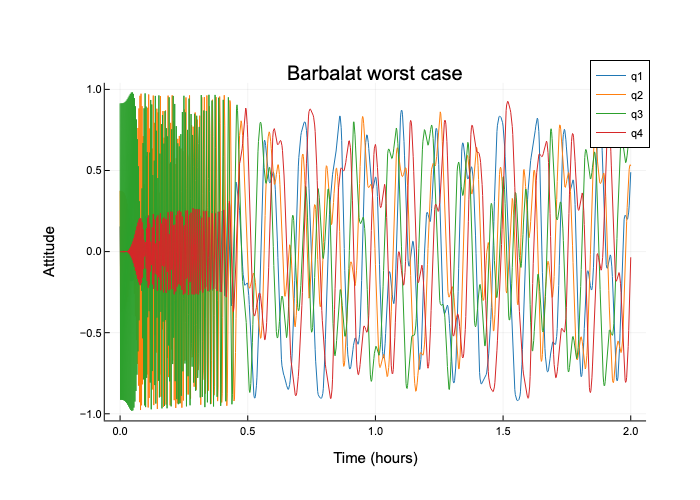

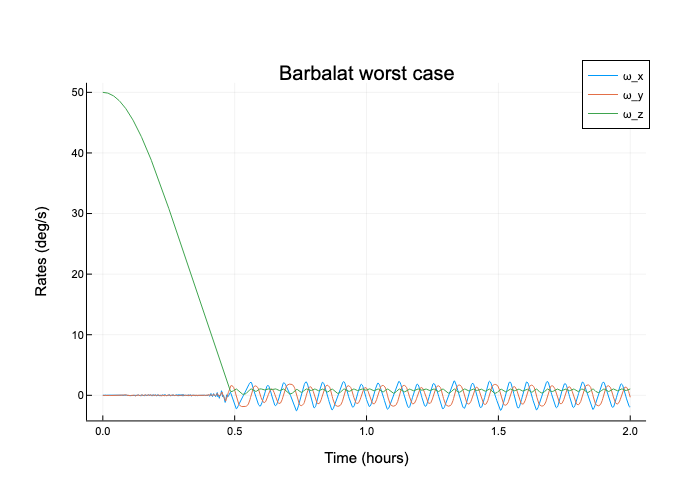

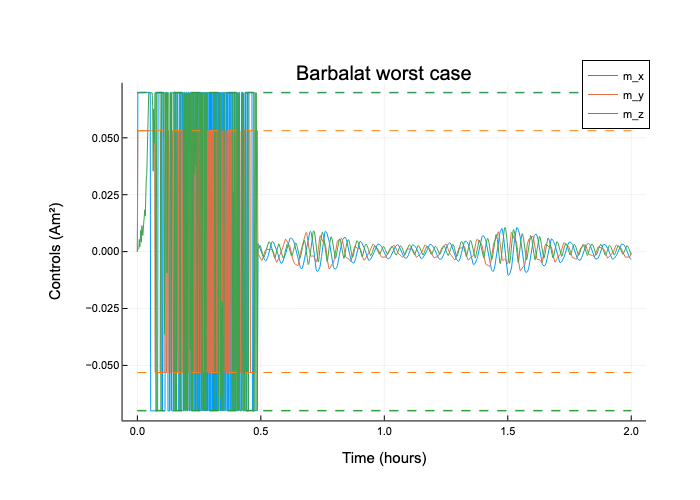

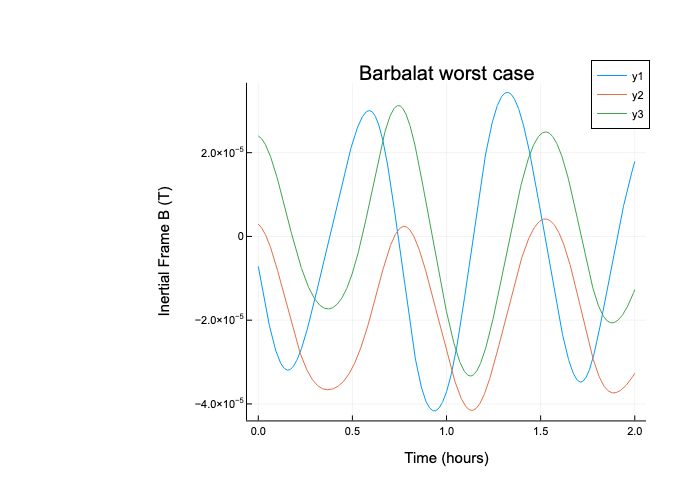

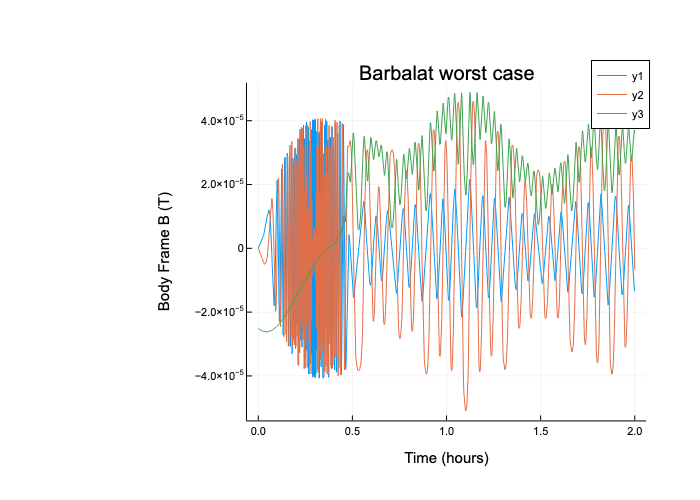

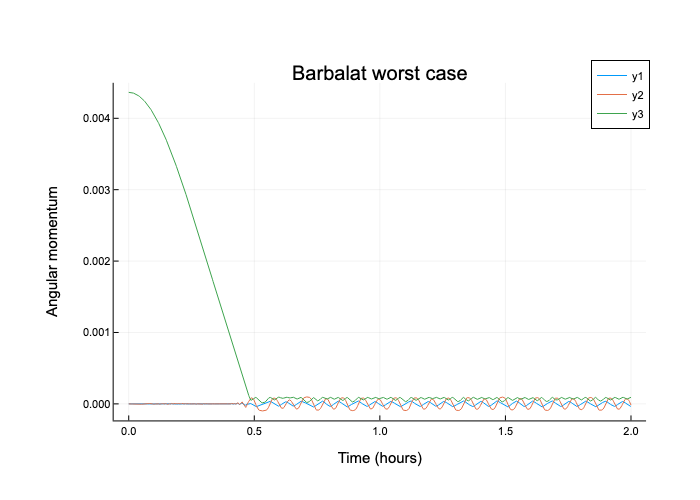

In [6]:
xhist_barbalat, uhist_barbalat, thist_barbalat = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> bbarbalat_minVd(x, t, m; k=1e2, saturate=true, tsolver=10.0), controller_dt=0.0)
# plot_position(thist_barbalat, xhist_barbalat; title="Barbalat worst case")
# plot_velocity(thist_barbalat, xhist_barbalat; title="Barbalat worst case")
display(plot_attitude(thist_barbalat, xhist_barbalat; title="Barbalat worst case"))
display(plot_rates(thist_barbalat, xhist_barbalat; title="Barbalat worst case"))
display(plot_controls(thist_barbalat, uhist_barbalat, params; title="Barbalat worst case"))
display(plot_B_inertial(thist_barbalat, xhist_barbalat, params; title="Barbalat worst case"))
display(plot_B_body(thist_barbalat, xhist_barbalat, params; title="Barbalat worst case"))
display(plot_angular_momentum(thist_barbalat, xhist_barbalat, params; title="Barbalat worst case"))
